<a href="https://colab.research.google.com/github/Hwismos/capstone-keras-based-model/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 환경 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# [05.05] CNN 기반의 모델 구성 방법

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Activation, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model

## 1. Sequential()

In [ ]:
# 모델이 순차적인 구조를 가질 때 사용 가능한 방법이다.
# 아래와 같은 방법 외에도 리스트를 이용해서 한 번에 구성할 수 있다. 

model = Sequential()
model.add(Input(shape=(28, 28)))
model.add(Flatten(input_shape = [28, 28]))

# 노드 수가 300개인 층인 층과 100개인 층을 통과한다.
model.add(Dense(300, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))

# 최종적으로 10개의 값을 출력한다.
model.add(Dense(10, activation = 'softmax'))

# Total params는 모델에서 학습시키는 가중치의 개수이다. 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


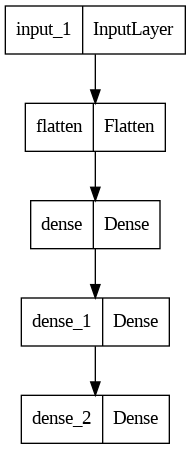

In [ ]:
# plot_model은 모델의 구조를 이미지로 확인해주는 함수이다.
plot_model(model)

## 함수형 API

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


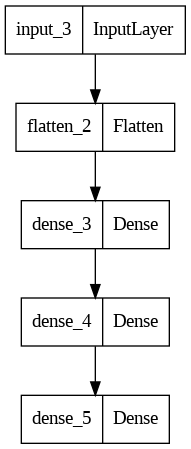

In [ ]:
# 모델을 복잡하고 유연하게 구성할 수 있어 권장되는 방법이다.
# 다중 입출력을 다룰 수 있다.
# 아래와 같이 함수형 API를 이용해 앞선 Sequential 모델과 동일한 모델을 구성했다.

inputs = Input(shape = (28, 28, 1))
x = Flatten(input_shape = (28, 28, 1))(inputs)
x = Dense(300, activation = 'relu')(x)
x = Dense(100, activation = 'relu')(x)
x = Dense(10, activation = 'softmax')(x)

model = Model(inputs = inputs, outputs = x)
model.summary()
plot_model(model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 28, 300)      8700        ['input_4[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 28, 30)       9030        ['dense_6[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 28, 58)       0           ['input_4[0][0]',                
                                                                  'dense_7[0][0]']          

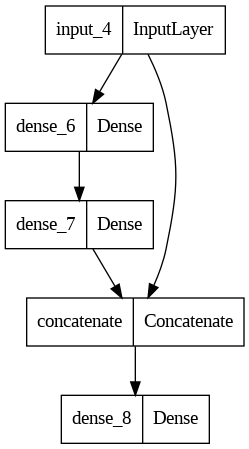

In [ ]:
# 함수형 API를 이용해 다중 입출력을 지원하는 모델을 구성한다.

from tensorflow.keras.layers import Concatenate

input_layer = Input(shape = (28, 28))
hidden = Dense(300, activation = 'relu')(input_layer)
hidden_1 = Dense(30, activation = 'relu')(hidden)
concat = Concatenate()([input_layer, hidden_1])
output = Dense(1)(concat)

model = Model(inputs = [input_layer], outputs = [output])
model.summary()
plot_model(model)

## 3. 서브 클래싱

In [ ]:
# 커스터마이징에 최적화된 방법이다.

class myModel(Model):
    def __init__(self, unit = 30, activation = 'relu', **kwargs):
        super(myModel, self).__init__(**kwargs)
        self.dense_layer1 = Dense(300, activation = activation)
        self.dense_layer2 = Dense(100, activation = activation)
        self.dense_layer3 = Dense(unit, activation = activation)
        self.output_layer = Dense(10, activation = 'softmax')
    
    def call(self, inputs):
        x = self.dense_layer1(inputs)
        x = self.dense_layer2(x)
        x = self.dense_layer3(x)
        x = self.output_layer(x)
        return x

In [ ]:
inputs = Input(shape = (28, 28, 1))
model = myModel()
x = model.call(inputs)
# print(x)

# [05.05] TensorFlow 모델 저장과 복원

## 설정

In [ ]:
# 모델을 HDF5 포맷으로 저장하기 우히ㅐ 필요한 라이브러리를 설치한다.

!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 주요 라이브러리를 임포트 한다.

import os
import tensorflow as tf
from tensorflow import keras
print(tf.version.VERSION)

2.12.0


In [ ]:
# MNIST 데이터셋으로 모델을 훈려하여 가중치를 저장하는 예제를 만든다.

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# 모델 학습 속도를 빠르게 하기 위해 샘플 중 1000개만 이용한다.
train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

# train, test images를 reshape 해주지 않아서 에러가 발생되었다. 

train_images = train_images[:1000].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:1000].reshape(-1, 28 * 28) / 255.0

In [ ]:
# 간단한 모델을 정의한다.

def create_model():
    model = tf.keras.Sequential([
        keras.layers.Dense(512, activation = 'relu', input_shape = (784,)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10)
    ])

    model.compile(optimizer = 'adam',
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
    
    return model

# 모델 객체(인스턴스)를 생성한다.
model = create_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 512)               401920    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


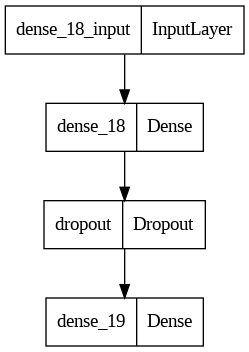

In [ ]:
plot_model(model)

## 훈련 중 체크포인트 저장하기

In [ ]:
# 훈련하는 동안 가중치를 저장하기 위한 ModelCheckpoint 콜백을 생성한다.

checkpoint_path = '/content/drive/MyDrive/4학년/캡스톤/study/training_1/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)   # 경로 중 디렉토리만 얻어 간다.

# 모델의 가중치를 저장하는 콜백을 생성한다.
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                 save_weights_only = True,
                                                 verbose = 1)

# 새 콜백을 이용해 모델을 학습시킨다.
model.fit(train_images,
          train_labels,
          epochs = 10,
          validation_data = (test_images, test_labels),
          callbacks=[cp_callback])  # 콜백을 학습 과정에 전달한다.

Epoch 1/10
29/32 [==========================>...] - ETA: 0s - loss: 1.2714 - sparse_categorical_accuracy: 0.6142
Epoch 1: saving model to /content/drive/MyDrive/4학년/캡스톤/study/training_1/cp.ckpt
32/32 [==============================] - 1s 18ms/step - loss: 1.2256 - sparse_categorical_accuracy: 0.6260 - val_loss: 0.7470 - val_sparse_categorical_accuracy: 0.7700
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 0.4444 - sparse_categorical_accuracy: 0.8780
Epoch 2: saving model to /content/drive/MyDrive/4학년/캡스톤/study/training_1/cp.ckpt
32/32 [==============================] - 0s 15ms/step - loss: 0.4444 - sparse_categorical_accuracy: 0.8780 - val_loss: 0.5488 - val_sparse_categorical_accuracy: 0.8170
Epoch 3/10
31/32 [============================>.] - ETA: 0s - loss: 0.2955 - sparse_categorical_accuracy: 0.9254
Epoch 3: saving model to /content/drive/MyDrive/4학년/캡스톤/study/training_1/cp.ckpt
32/32 [==============================] - 0s 15ms/step -

In [ ]:
os.listdir(checkpoint_dir)

['cp.ckpt.index', 'cp.ckpt.data-00000-of-00001', 'checkpoint']

In [ ]:
# 가중치가 공유됨을 확인하기 위해 모델 객체를 다시 생성하고 평가를 진행한다.
# 이전에는 실수로 TopK 평가 메트릭을 이용해서 학습되지 않은 모델 객체의 정확도도 40%를 기록했다.
# categorical_accuracy로 평가 메트릭을 변경한 뒤 12.80%의 정확도를 산출했다.

model = create_model()
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("학습되지 않은 모델의 정확도: {:5.2f}%".format(100 * acc))

32/32 - 1s - loss: 2.3001 - sparse_categorical_accuracy: 0.1280 - 562ms/epoch - 18ms/step
학습되지 않은 모델의 정확도: 12.80%


In [ ]:
# 체크포인트에서 가중치를 로드한 뒤 평가를 재진행한다.
# 86.60%를 산출했다.
# ckpt는 체크포인트 포맷의 파일로 바이너리 포맷의 가중치만을 저장하고 있다.

model.load_weights(checkpoint_path)
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("저장된 가중치를 이용한 모델의 정확도: {:5.2f}%".format(100 * acc))

32/32 - 0s - loss: 0.4209 - sparse_categorical_accuracy: 0.8660 - 79ms/epoch - 2ms/step
저장된 가중치를 이용한 모델의 정확도: 86.60%


## 전체 모델 저장하기

In [ ]:
# tf.keras.Model.save 메소드를 이용해 모델의 아키텍처, 가중치 및 훈련 수성을 저장할 수 있다.
# 이렇게 하면 Python 코드에 접근하지 않고도 모델을 사용할 수 있다.

# 기본적으로 저장되는 모델의 파일 형식은 TF2.x 이지만 HDF5 형식으로도 가능하다. 
# 완전한 기능의 모델을 저장하면 TensorFlow.js에서 로드한 뒤 웹 브라우저에서 실행할 수 있다.

### SavedModel 포맷

In [ ]:
# SavedModel 형식은 pb(protobuf binary)와 체크포인트 파일을 저장하는 디렉토리다.

# 모델 객체를 생성한 뒤 학습시킨다.
model = create_model()
model.fit(train_images, train_labels, epochs=5)

# 모델 자체를 SavedModel로 저장한다.
!mkdir -p saved_model
model.save('./saved_model/my_model')

Epoch 1/5
32/32 [==============================] - 1s 7ms/step - loss: 1.1376 - sparse_categorical_accuracy: 0.6680
Epoch 2/5
32/32 [==============================] - 0s 7ms/step - loss: 0.4100 - sparse_categorical_accuracy: 0.8830
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 0.2959 - sparse_categorical_accuracy: 0.9180
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: 0.2062 - sparse_categorical_accuracy: 0.9580
Epoch 5/5
32/32 [==============================] - 0s 8ms/step - loss: 0.1510 - sparse_categorical_accuracy: 0.9700


In [ ]:
# 저장된 모델로부터 새로운 케라스 모델을 로드한다.

new_model = tf.keras.models.load_model('./saved_model/my_model')
new_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 512)               401920    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('SavedModel 포맷을 이용해 로드한 모델의 정확도: {:5.2f}%'.format(100*acc))

print(new_model.predict(test_images).shape)

32/32 - 0s - loss: 0.4313 - sparse_categorical_accuracy: 0.8600 - 83ms/epoch - 3ms/step
SavedModel 포맷을 이용해 로드한 모델의 정확도: 86.00%
32/32 [==============================] - 0s 2ms/step
(1000, 10)


### HDF5 파일로 저장하기

In [ ]:
model = create_model()
model.fit(train_images, train_labels, epochs=5)

# '.h5' 확장자는 모델이 HDF5 형식으로 저장됨을 가리킨다.
model.save('./my_model.h5')

Epoch 1/5
32/32 [==============================] - 1s 7ms/step - loss: 1.1756 - sparse_categorical_accuracy: 0.6630
Epoch 2/5
32/32 [==============================] - 0s 8ms/step - loss: 0.4325 - sparse_categorical_accuracy: 0.8820
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: 0.2883 - sparse_categorical_accuracy: 0.9280
Epoch 4/5
32/32 [==============================] - 0s 8ms/step - loss: 0.2232 - sparse_categorical_accuracy: 0.9420
Epoch 5/5
32/32 [==============================] - 0s 7ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.9600


In [ ]:
new_model = tf.keras.models.load_model('./my_model.h5')

new_model.summary()
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 512)               401920    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_39 (Dense)            (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
32/32 - 1s - loss: 0.4307 - sparse_categorical_accuracy: 0.8620 - 596ms/epoch - 19ms/step
Restored model, accuracy: 86.20%


# -